In [109]:
import numpy as np
import seaborn as sb
import pandas as pd
import time
import statistics
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import tensorflow as tf
from tensorflow import keras

# Loading & Preprocessing Data

In [2]:
train_df = pd.read_csv('train.tsv', delimiter='\t', header=None)
test_df = pd.read_csv('test.tsv', delimiter='\t', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
0,-1,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,-0.296780,-0.513929,-0.255645,-0.107203,-0.287827,-0.418009,-0.319163,-0.260379,-0.350357,-0.505486,-0.710887,-0.823920,-0.899702,-1.153950,-1.229831,-1.044091,-1.202031,-1.392195,-1.130108,-1.179867,-1.649272,-1.726575,-1.608370,-1.662802,-1.650672,-1.697309,-1.838697,-1.802596,-1.780536,...,0.683870,0.474995,0.532797,0.723550,0.664420,0.647936,0.757054,0.732072,0.620215,0.606297,0.677950,0.689084,0.598807,0.542647,0.581807,0.630631,0.664420,0.686318,0.657383,0.650889,0.721738,0.739706,0.691481,0.695229,0.750115,0.853845,0.916019,0.827750,0.880906,1.088831,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,-1.055926,-1.128777,-0.686039,-0.798789,-1.714279,-1.649858,-1.032699,-1.423918,-1.782433,-1.025126,-1.798909,-1.793614,-1.085478,-1.574390,-1.036059,-2.130021,-2.038621,-0.055013,-1.140195,-0.704275,0.048723,-0.475854,0.525865,0.244778,0.679932,0.928601,0.573041,1.231607,1.043324,...,0.631120,0.694075,0.515071,0.559229,0.555712,0.469694,0.388821,0.343129,0.535598,0.900708,0.656846,0.690033,0.952596,0.547770,-0.167693,0.011532,-0.176488,-0.277706,-0.224836,-0.910723,-0.037932,0.071668,-1.048920,-0.636218,-0.386637,-0.507512,-0.716656,-0.463758,-0.460442,-0.770792,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,-0.022363,-0.235318,-0.118273,-0.071027,-0.322986,-0.433562,-0.318660,-0.295655,-0.417733,-0.682480,-0.881840,-0.843320,-0.883652,-1.030018,-1.055265,-1.168637,-1.363991,-1.337611,-1.261294,-1.409782,-1.634504,-1.703238,-1.677025,-1.782628,-1.996872,-2.056372,-1.937881,-1.879412,-1.915427,...,0.675666,0.699885,0.732561,0.771665,0.738129,0.723699,0.806876,0.878984,0.855791,0.806384,0.792501,0.803814,0.781938,0.700439,0.735960,0.864162,0.707670,0.458756,0.600146,0.825136,0.800034,0.762821,0.755443,0.653766,0.526441,0.477339,0.574946,0.698425,0.722414,0.771598,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,0.989227,0.821253,0.576448,0.743089,0.852970,0.307458,-0.130391,-0.062200,-0.100727,-0.232818,-0.234465,-0.214756,-0.230413,-0.227551,-0.231002,-0.463479,-0.724215,-0.787885,-0.986687,-1.224672,-1.288142,-1.364148,-1.428221,-1.501767,-1.648084,-1.705836,-1.686790,-1.705719,-1.777683,-1.869313,...,0.405055,0.464974,0.434163,0.486807,0.439388,0.369611,0.413149,0.397895,0.318764,0.263717,0.288863,0.358244,0.326737,0.229215,0.204418,0.244386,0.262632,0.243885,0.227502,0.245785,0.232959,0.164611,0.171538,0.166690,0.099141,0.146937,0.133414,0.125294,0.202713,0.186409,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,0.701402,1.006133,0.395784,-0.369703,-0.738202,-0.729084,-0.906940,-0.870962,-1.060217,-1.197958,-0.981602,-1.272497,-1.287380,-1.276698,-1.539702,-1.346610,-1.535217,-1.763418,-1.688821,-1.809369,-1.863891,-1.994453,-1.889810,-1.925713,-1.833629,-1.661830,-1.342510,-1.011317,-0.672717,-0.216157,...,0.543004,0.453148,0.485785,0.440679,0.539153,0.369571,0.377316,0.470113,0.321448,0.325513,0.251259,0.270571,0.277161,0.155171,0.120954,0.326395,0.473952,0.594736,0.698199,0.826781,0.575166,0.401196,0.349966,0.148053,-0.033206,-0.114266,0.120345,-0.220102,-0.151226,-0.077445,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


In [3]:
y_train_raw = train_df.values[:,0]
x_train_raw = train_df.values[:,1:]

y_test_raw = test_df.values[:,0]
x_test_raw = test_df.values[:,1:]

In [4]:
print('#features:', len(train_df.columns)-1)
print('#negative samples on training:', np.where(train_df.iloc[:,0] == -1)[0].shape[0])
print('#positive samples on training:', np.where(train_df.iloc[:,0] == 1)[0].shape[0])
print('#negative samples on testing:', np.where(test_df.iloc[:,0] == -1)[0].shape[0])
print('#positive samples on testing:', np.where(test_df.iloc[:,0] == 1)[0].shape[0])

#features: 96
#negative samples on training: 31
#positive samples on training: 69
#negative samples on testing: 36
#positive samples on testing: 64


In [5]:
def preprocess(x_train, y_train, x_test, y_test):
  # normalizing data
  x_train = normalize(x_train)
  x_test = normalize(x_test)

  # reshaping data according to model input format
  x_train = x_train.reshape(100, -1, 1)
  x_test = x_test.reshape(100, -1, 1)

  # mapping y_train and y_test to {0, 1}
  enc = LabelEncoder()
  y_train_bin = enc.fit_transform(y_train.reshape(-1,1))
  y_test_bin = enc.fit_transform(y_test.reshape(-1,1))

  # one-hot encoding of y_train and y_test
  enc = OneHotEncoder()
  y_train_bin = enc.fit_transform(y_train_bin.reshape(-1,1)).toarray()
  y_test_bin = enc.fit_transform(y_test_bin.reshape(-1,1)).toarray()

  return x_train, y_train_bin, x_test, y_test_bin

In [6]:
x_train, y_train_bin, x_test, y_test_bin = preprocess(x_train_raw, y_train_raw, 
                                                      x_test_raw, y_test_raw)

print(x_train.shape, y_train_bin.shape)
print(x_test.shape, y_test_bin.shape)

(100, 96, 1) (100, 2)
(100, 96, 1) (100, 2)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Visualizing

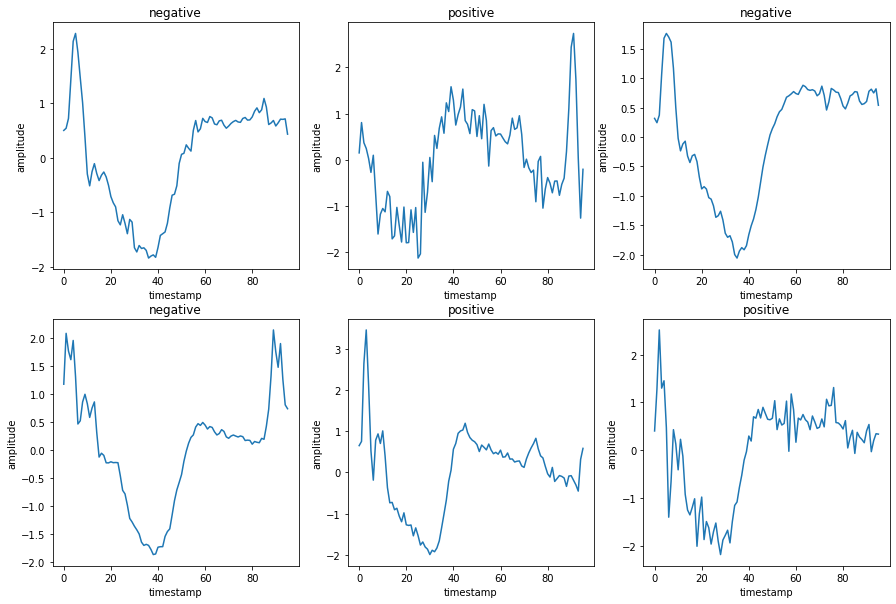

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
labels = ['', 'positive', 'negative']
for i in range(6):
  axs[i//3, i%3].plot(x_train_raw[i])
  axs[i//3, i%3].set_xlabel('timestamp')
  axs[i//3, i%3].set_ylabel('amplitude')
  axs[i//3, i%3].set_title(labels[int(y_train_raw[i])])

# Building Models

## Building CNN

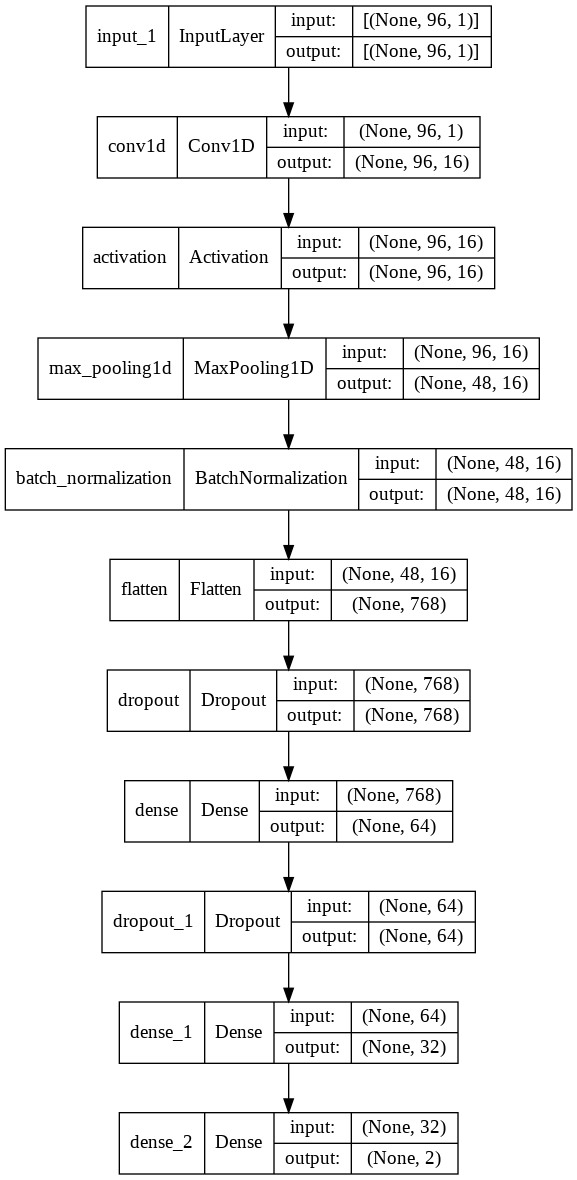

In [8]:
def build_cnn(n_conv=1, n_dense=1, min_kernels=16, min_units=64):
  tf.keras.backend.clear_session()

  inputs = keras.layers.Input(shape=(x_train.shape[1:]))
  tmp = inputs

  for i in range(n_conv):
    conv1D = keras.layers.Conv1D(min_kernels*2**(n_conv-1-i), 
                                 kernel_size=3, padding='same')(tmp)
    activ = keras.layers.Activation('relu')(conv1D)
    pool1D = keras.layers.MaxPool1D(2)(activ)
    batch_norm = keras.layers.BatchNormalization()(pool1D)
    tmp = batch_norm

  flatten = keras.layers.Flatten()(batch_norm)
  tmp = flatten

  for i in range(n_dense):
    dropout = keras.layers.Dropout(rate=0.2)(tmp)
    dense = keras.layers.Dense(min_units*2**(n_dense-1-i), 
                               activation='sigmoid')(dropout)
    tmp = dense
  
  outputs = keras.layers.Dense(2, activation='softmax')(dense)

  cnn_model = keras.models.Model(inputs, outputs, name='CNN')
  cnn_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy,
                metrics=['accuracy'])
  return cnn_model

cnn_model = build_cnn(n_conv=1, n_dense=2, min_kernels=16, min_units=32)
keras.utils.plot_model(cnn_model, 'cnn_arch.png', show_shapes=True)

In [150]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 96, 16)            64        
                                                                 
 activation (Activation)     (None, 96, 16)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 16)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 16)           64        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 768)               0       

In [9]:
hist = cnn_model.fit(x_train, y_train_bin, batch_size=64, epochs=300, validation_split=0.3, 
                     callbacks=[keras.callbacks.ModelCheckpoint('cnn_best.h5')], verbose=0)

cnn_model = keras.models.load_model('cnn_best.h5')
loss, acc = cnn_model.evaluate(x_test, y_test_bin, verbose=0)
print(f'loss: {loss} - accuracy: {acc}')

loss: 0.5516151189804077 - accuracy: 0.8299999833106995


precision: [0.75675676 0.87301587]
recall: [0.77777778 0.859375  ]
fscore: [0.76712329 0.86614173]
support: [36 64]


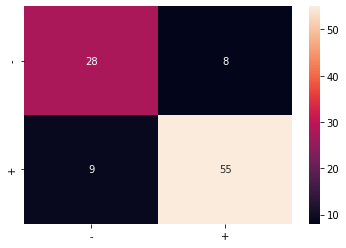

In [10]:
y_pred_bin = cnn_model.predict(x_test)
y_pred = [np.where(y == np.amax(y))[0][0]*2-1 for y in y_pred_bin]

prfs = precision_recall_fscore_support(y_test_raw, y_pred)
print('precision:', prfs[0])
print('recall:', prfs[1])
print('fscore:', prfs[2])
print('support:', prfs[3])

conf_mat = confusion_matrix(y_test_raw, y_pred)
sb.heatmap(pd.DataFrame(conf_mat, columns=['-', '+'], 
                        index=['-', '+']), annot=True);

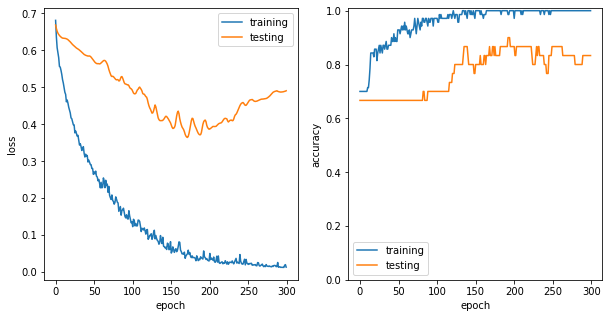

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(hist.history['loss'], label='training')
axs[0].plot(hist.history['val_loss'], label='testing')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].plot(hist.history['accuracy'], label='training')
axs[1].plot(hist.history['val_accuracy'], label='testing')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0, 1.01)
axs[1].legend()

### Visualizing Kernels & Feature Maps

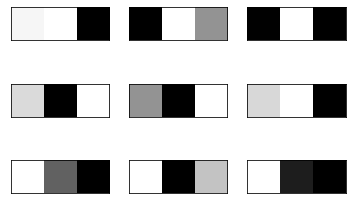

In [49]:
filters, biases = cnn_model.layers[1].get_weights()
fmin, fmax = filters.min(), filters.max()
# normalizing filters
filters = (filters - fmin) / (fmax - fmin)

n_filter, ix = 9, 1
for i in range(n_filter):
  f = filters[:, :, i]
  ax = plt.subplot(3, 3, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(f[:, j].reshape(1, 3), cmap='gray')
  ix += 1

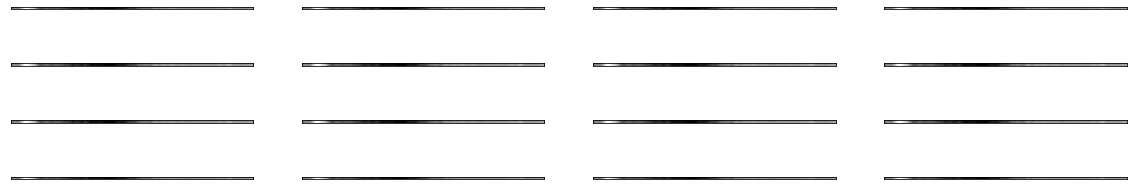

In [73]:
tmp_model = keras.models.Model(cnn_model.inputs, cnn_model.layers[1].output)
feature_maps = tmp_model.predict(x_train)

n, ix = 4, 1
fig, axs = plt.subplots(n, n, figsize=(5*n, n))
for i in range(n*n):
  axs[i//n, i%n].set_xticks([])
  axs[i//n, i%n].set_yticks([])
  axs[i//n, i%n].imshow(feature_maps[0, :, ix-1].reshape(1, 96), cmap='gray')

## Building RNN

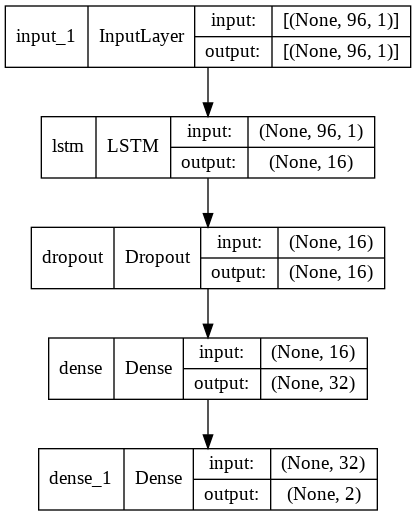

In [74]:
def build_rnn(n_lstm=1, n_dense=1, min_states=32, min_units=64):
  tf.keras.backend.clear_session()

  inputs = keras.layers.Input(shape=(x_train.shape[1:]))
  tmp = inputs

  for i in range(n_lstm):
    lstm = keras.layers.LSTM(min_states*2**(n_lstm-1-i), activation='tanh', 
                             recurrent_activation='sigmoid', return_sequences=(n_lstm-1-i))(tmp)
    tmp = lstm

  for i in range(n_dense):
    dropout = keras.layers.Dropout(rate=0.2)(tmp)
    dense = keras.layers.Dense(min_units*2**(n_dense-1-i), 
                               activation='sigmoid')(dropout)
    tmp = dense
  
  outputs = keras.layers.Dense(2, activation='softmax')(dense)

  rnn_model = keras.models.Model(inputs, outputs, name='RNN')
  rnn_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy,
                metrics=['accuracy'])
  return rnn_model

rnn_model = build_rnn(n_lstm=1, n_dense=1, min_states=16, min_units=32)
keras.utils.plot_model(rnn_model, 'rnn_arch.png', show_shapes=True)

In [149]:
rnn_model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,762
Trainable params: 1,762
Non-trainable params: 0
_________________________________________________________________


In [75]:
hist = rnn_model.fit(x_train, y_train_bin, batch_size=64, epochs=300, validation_split=0.3, 
                     callbacks=[keras.callbacks.ModelCheckpoint('rnn_best.h5')], verbose=0)

rnn_model = keras.models.load_model('rnn_best.h5')
loss, acc = rnn_model.evaluate(x_test, y_test_bin, verbose=0)
print(f'loss: {loss} - accuracy: {acc}')

loss: 0.5660218000411987 - accuracy: 0.7099999785423279


precision: [0.58139535 0.80701754]
recall: [0.69444444 0.71875   ]
fscore: [0.63291139 0.76033058]
support: [36 64]


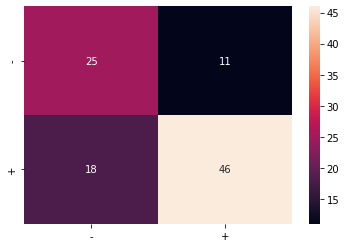

In [76]:
y_pred_bin = rnn_model.predict(x_test)
y_pred = [np.where(y == np.amax(y))[0][0]*2-1 for y in y_pred_bin]

prfs = precision_recall_fscore_support(y_test_raw, y_pred)
print('precision:', prfs[0])
print('recall:', prfs[1])
print('fscore:', prfs[2])
print('support:', prfs[3])

conf_mat = confusion_matrix(y_test_raw, y_pred)
sb.heatmap(pd.DataFrame(conf_mat, columns=['-', '+'], 
                        index=['-', '+']), annot=True);

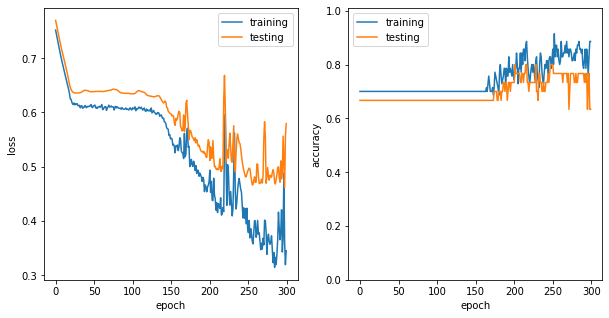

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(hist.history['loss'], label='training')
axs[0].plot(hist.history['val_loss'], label='testing')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()

axs[1].plot(hist.history['accuracy'], label='training')
axs[1].plot(hist.history['val_accuracy'], label='testing')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0, 1.01)
axs[1].legend()

### Visualizing LSTM Activations & Weights

# Benchmarking

In [142]:
'''
  @param model  - model type, values: 'cnn' or 'rnn'
  @param X      - [x_train, x_test]
  @param y      - [y_train_bin, y_test_bin]
  @param n_run  - number of model training/testing
'''
def benchmark(model, X, y, epochs, n_run):
  accs, val_accs = [0]*epochs, [0]*epochs
  losses, val_losses = [0]*epochs, [0]*epochs
  test_accs, test_losses = [0]*n_run, [0]*n_run
  train_accs, train_losses = [0]*n_run, [0]*n_run
  model, time_elapsed = None, 0
  prfs_mat = np.zeros(shape=(4,2))

  for i in range(n_run):
    if model == 'cnn':
      model = build_cnn(n_conv=1, n_dense=2, min_kernels=16, min_units=32)
    else: # 'rnn'
      model = build_rnn(n_lstm=1, n_dense=1, min_states=16, min_units=32)
    start = time.perf_counter()
    hist = model.fit(X[0], y[0], batch_size=64, epochs=epochs, 
                     validation_split=0.3, verbose=False, 
                     callbacks=[keras.callbacks.ModelCheckpoint('best.h5')])
    time_elapsed += (time.perf_counter()-start) / n_run
    model = keras.models.load_model('best.h5')

    # evaluations on training and testing datasets
    loss, acc = model.evaluate(X[1], y[1], verbose=0)
    test_losses[i] = loss
    test_accs[i] = acc

    loss, acc = model.evaluate(X[0], y[0], verbose=0)
    train_losses[i] = loss
    train_accs[i] = acc

    # processing confusion matrix
    y_pred_bin = model.predict(x_test)
    y_pred = [np.where(y == np.amax(y))[0][0]*2-1 for y in y_pred_bin]
    prfs = precision_recall_fscore_support(y_test_raw, y_pred)
    for i in range(4):
      prfs_mat[i,0] += prfs[i][0] / n_run
      prfs_mat[i,1] += prfs[i][1] / n_run

    # processing training history
    for i, (acc, val_acc, loss, val_loss) in enumerate(zip(hist.history['accuracy'], 
                                                           hist.history['val_accuracy'], 
                                                           hist.history['loss'], 
                                                           hist.history['val_loss'])):
      accs[i] += acc / n_run
      val_accs[i] += val_acc / n_run
      losses[i] += loss / n_run
      val_losses[i] += val_loss / n_run
  
  train_test_data = (np.mean(train_losses), np.mean(train_accs), np.std(train_losses)), (np.mean(test_losses), np.mean(test_accs), np.std(test_losses))
  stats = (losses, val_losses, accs, val_accs, time_elapsed)

  return train_test_data, prfs_mat, stats

In [143]:
epochs, N = 300, 5
X = [x_train, x_test]
y = [y_train_bin, y_test_bin]

cnn_train_test_result, cnn_prfs, cnn_stats = benchmark('cnn', X, y, epochs, N)
rnn_train_test_result, rnn_prfs, rnn_stats = benchmark('rnn', X, y, epochs, N)

print(f'[CNN]training> loss: {cnn_train_test_result[0][0]} - accuracy: {cnn_train_test_result[0][1]}')
print(f'[CNN]testing> loss: {cnn_train_test_result[1][0]} - accuracy: {cnn_train_test_result[1][1]}')
print(f'[RNN]training> loss: {rnn_train_test_result[0][0]} - accuracy: {rnn_train_test_result[0][1]}')
print(f'[RNN]testing> loss: {rnn_train_test_result[1][0]} - accuracy: {rnn_train_test_result[1][1]}')

[CNN]training> loss: 0.3601770579814911 - accuracy: 0.8460000038146973
[CNN]testing> loss: 0.5273182630538941 - accuracy: 0.7480000019073486
[RNN]training> loss: 0.37894737124443056 - accuracy: 0.8459999918937683
[RNN]testing> loss: 0.5199663519859314 - accuracy: 0.75


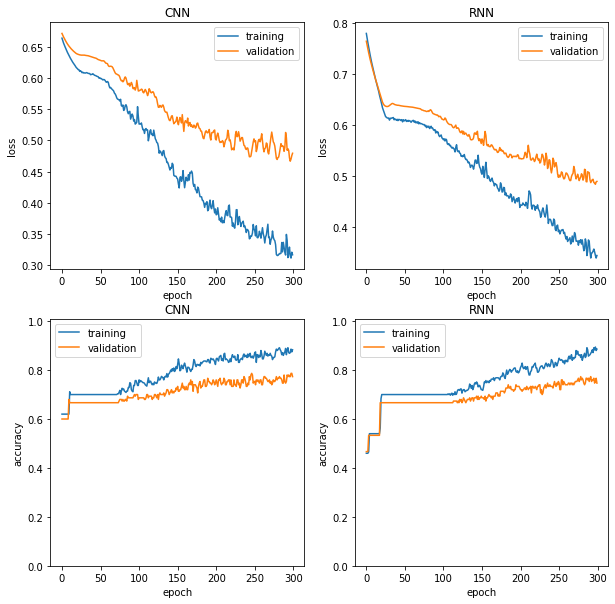

In [144]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(cnn_stats[0], label='training')
axs[0,0].plot(cnn_stats[1], label='validation')
axs[0,0].set_xlabel('epoch')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('CNN')
axs[0,0].legend()

axs[0,1].plot(rnn_stats[0], label='training')
axs[0,1].plot(rnn_stats[1], label='validation')
axs[0,1].set_xlabel('epoch')
axs[0,1].set_ylabel('loss')
axs[0,1].set_title('RNN')
axs[0,1].legend()

axs[1,0].plot(cnn_stats[2], label='training')
axs[1,0].plot(cnn_stats[3], label='validation')
axs[1,0].set_xlabel('epoch')
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('CNN')
axs[1,0].set_ylim(0, 1.01)
axs[1,0].legend()

axs[1,1].plot(rnn_stats[2], label='training')
axs[1,1].plot(rnn_stats[3], label='validation')
axs[1,1].set_xlabel('epoch')
axs[1,1].set_ylabel('accuracy')
axs[1,1].set_title('RNN')
axs[1,1].set_ylim(0, 1.01)
axs[1,1].legend();

In [146]:
stats = np.array([['', 'CNN', 'RNN'],
                  ['Loss mean', round(cnn_train_test_result[1][0],3), round(rnn_train_test_result[1][0],3)],
                  ['Loss std', round(cnn_train_test_result[1][2],3), round(rnn_train_test_result[1][2],3)],
                  ['Accuracy', round(cnn_train_test_result[1][1],3), round(rnn_train_test_result[1][1],3)],
                  ['Precision', f'{round(cnn_prfs[0,0],2)} | {round(cnn_prfs[0,1],2)}', f'{round(rnn_prfs[0,0],2)} | {round(rnn_prfs[0,1],2)}'],
                  ['Recall', f'{round(cnn_prfs[1,0],2)} | {round(cnn_prfs[1,1],2)}', f'{round(rnn_prfs[1,0],2)} | {round(rnn_prfs[1,1],2)}'],
                  ['F1-score', f'{round(cnn_prfs[2,0],2)} | {round(cnn_prfs[2,1],2)}', f'{round(rnn_prfs[2,0],2)} | {round(rnn_prfs[2,1],2)}'],
                  ['Time elapsed(s)', round(cnn_stats[-1],2), round(rnn_stats[-1],2)]])
stats_df = pd.DataFrame(stats[1:,1:], index=stats[1:,0], columns=stats[0,1:])
stats_df

,CNN,RNN
Loss mean,0.527,0.52
Loss std,0.012,0.012
Accuracy,0.748,0.75
Precision,0.66 | 0.8,0.67 | 0.79
Recall,0.63 | 0.82,0.61 | 0.83
F1-score,0.64 | 0.8,0.63 | 0.81
Time elapsed(s),42.64,40.53


**Interpretation.** To benchmark the developed models, each model has been retrained from scratch 20 times. We can observe from the table shown above that both CNN and RNN models are robust in terms of std(loss) and they are also relatively performant in terms of mean(loss). Both models show similar results in terms of accuracy, precision, recall and f1-score. According to the elapsed time to train each model, CNN usually takes more time(~2.1 seconds) than RNN.